In [32]:
from valurap import path_planning
import imp
import seaborn as sns

imp.reload(path_planning)

%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt



In [34]:
errors = []
solve = path_planning.solve_model_simple(0, 1370000-50000, 5000, 50, 300, errors)
solve
#df = pd.DataFrame(errors)
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=19, weights=df["delta_v"]*df["delta_v"]+df["jerk"]*df["jerk"])
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=19, weights=abs(df["jerk"]/250000))
#hist = np.histogram2d(x=df["dj"], y=df["djj"], bins=20*3*2+1, weights=abs(df["end_a"]/700000000) + abs(df["jerk"]/250000))
#print(hist[0])

#fig, ax = plt.subplots(figsize=(20, 10))
#im = ax.imshow(hist[0])
#cbar = fig.colorbar(im)

      fun: 0.01046018281566516
 hess_inv: array([[0.15892097, 0.1548804 ],
       [0.1548804 , 0.15826993]])
      jac: array([ 0.01275218, -0.01089168])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 303
      nit: 8
     njev: 73
   status: 2
  success: False
        x: array([-0.90945365,  1.11297413])
old 207618050 -8304722
new 205729860 -8397151


{'accel_j': 205729860,
 'accel_jj': -8397151,
 'plato_v': 1324923.5173797607,
 'accel_x': 372.7580698686949,
 'plato_x': 4627.241930155179}

In [35]:
from math import sqrt
from numpy import array, absolute, isnan
from numpy.linalg import norm

from valurap import printer, commands
from valurap.asg import Asg, ProfileSegment, PathSegment

path_deltas = [
    [100.0, 100.0, 200.0],
    [100.0, -100.0, 100.0],
    [100.0, -200.0, 200.0],
    [-150.0, -50.0, 150.0],
    [-150.0, 150.0, 150.0],
    [10.0, -200.0, 200.0],
    [50.0, 200.0, 200.0],
    [-60.0, 100.0, 200.0],
] * 3

path_deltas = [
    [120.0, -0.0, 250.0],
    [-0.0, 120.0, 250.0],
    [-120.0, 50.0, 250.0],
    [50.0, -120.0, 250.0],
    [-50.0, -50.0, 150.0],
] * 3

path_deltas = [
    [10, 250.0, 200.0],
    [1, 25.0, 50.0],
    [2, 0.0, 30.0],
    [-1, -25.0, 50.0],
    [-10, -250.0,  200.0],
    [-1, -25.0, 50.0],
    [-2, 0.0, 30.0],
    [1, 25.0, 50.0],
] * 10

 
path_deltas = []
l = 30
v = 160

for i in range(0, 10):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*l,      0, v])
    path_deltas.append([       0, -k*l, v])
    path_deltas.append([ -k2*l,      0, v])
    path_deltas.append([       0, k2*l, v])
    

path = []
x = 0
y = 0
for dx, dy, speed in path_deltas:
    x += dx
    y += dy
    path.append([x, y, speed])
    
print(path)

pr_opt = path_planning.plan_path([0, 0], path, fatal=False)
import warnings
warnings.filterwarnings("error")

steps_opt = path_planning.emulate(pr_opt, 0)
steps_opt = pd.DataFrame(steps_opt)




[[60.0, 0, 160], [60.0, -60.0, 160], [0.75, -60.0, 160], [0.75, -0.75, 160], [59.25, -0.75, 160], [59.25, -59.25, 160], [1.5, -59.25, 160], [1.5, -1.5, 160], [58.5, -1.5, 160], [58.5, -58.5, 160], [2.25, -58.5, 160], [2.25, -2.25, 160], [57.75, -2.25, 160], [57.75, -57.75, 160], [3.0, -57.75, 160], [3.0, -3.0, 160], [57.0, -3.0, 160], [57.0, -57.0, 160], [3.75, -57.0, 160], [3.75, -3.75, 160], [56.25, -3.75, 160], [56.25, -56.25, 160], [4.5, -56.25, 160], [4.5, -4.5, 160], [55.5, -4.5, 160], [55.5, -55.5, 160], [5.25, -55.5, 160], [5.25, -5.25, 160], [54.75, -5.25, 160], [54.75, -54.75, 160], [6.0, -54.75, 160], [6.0, -6.0, 160], [54.0, -6.0, 160], [54.0, -54.0, 160], [6.75, -54.0, 160], [6.75, -6.75, 160], [53.25, -6.75, 160], [53.25, -53.25, 160], [7.5, -53.25, 160], [7.5, -7.5, 160]]
speeds: prev [0 0] current [160.   0.] next [   0. -160.]
avails: prev [0 0] current [60.  0.] next [  0. -30.]
enter_delta_v: [160.   0.]
enter_time: 0.05333333333333334
enter_a: [3000.    0.]
enter_de

<IPython.core.display.Javascript object>


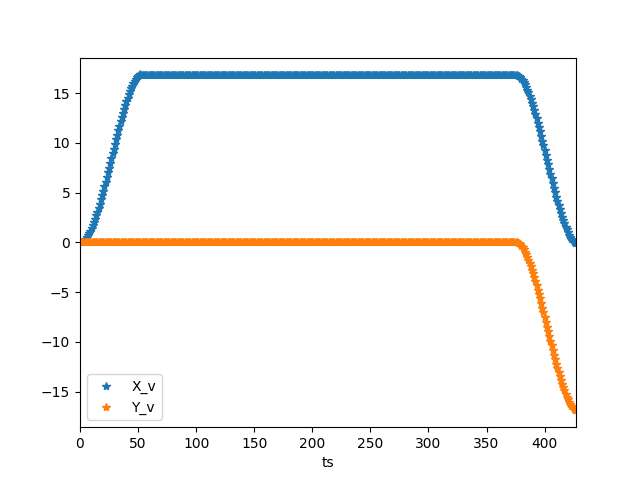

In [36]:
%matplotlib notebook
#steps_opt.plot(x = steps_opt["X_x"]/80, y = steps_opt["Y_x"]/80, style="*")

#steps_opt.plot(x = "ts", y = ["X_a", "Y_a"], style="*")
steps_opt.plot(x = "ts", y = ["X_v", "Y_v"], style="*")
#steps_opt.plot(x = "ts", y = ["X_x", "Y_x"], style="*")
if 0:
    steps_opt["X_x1"] = steps_opt["X_x"]/80
    steps_opt["Y_x1"] = steps_opt["Y_x"]/80

    steps_opt.plot(x = "X_x1", y = "Y_x1", style="*")

#code = p.asg.gen_path_code(pr_opt)
#print(len(code))
#print(code)
            

In [ ]:
path_deltas = []

for i in range(0, 20):
    k = 2 - 0.05 * i
    k2 = 2 - 0.05 * (i + 0.5)
    path_deltas.append([   k*100,      0, 50])
    path_deltas.append([       0, -k*100, 50])
    path_deltas.append([ -k2*100,      0, 50])
    path_deltas.append([       0, k2*100, 50])

path_deltas